In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [48]:
cd "/content/drive/My Drive/ML"

/content/drive/My Drive/ML


In [0]:
from pathlib import Path

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

RANDOM_SEED = 8    # Set a random seed for reproducibility!
pd.set_option("display.max_columns", 100)

In [0]:
DATA_PATH = Path.cwd().parent / "data" / "final" / "public"

train_df = pd.read_csv(
    DATA_PATH / "/content/drive/My Drive/ML/train.csv", 
    index_col="tripid"
)
test_features_df = pd.read_csv(
    DATA_PATH / "/content/drive/My Drive/ML/test.csv", 
    index_col="tripid"
)

In [0]:
labels_df = train_df[['label']]
features_df = train_df.drop('label', axis=1)

In [0]:
labels_df=labels_df.replace("correct", 1)
labels_df=labels_df.replace("incorrect", 0)

In [0]:
features_df = features_df.fillna(features_df.mean())
test_features_df = test_features_df.fillna(test_features_df.mean())

In [0]:
def haversine_array(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    avg_earth_radius = 6371  # in km
    lat = lat2 - lat1
    lon = lon2 - lon1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon * 0.5) ** 2
    h = 2 * avg_earth_radius * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lon1, lat2, lon2):
    a = haversine_array(lat1, lon1, lat1, lon2)
    b = haversine_array(lat1, lon1, lat2, lon1)
    return a + b

def bearing_array(lat1, lon1, lat2, lon2):
    avg_earth_radius = 6371  # in km
    lon_delta_rad = np.radians(lon2 - lon1)
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    y = np.sin(lon_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [0]:
features_df['distance_haversine'] = haversine_array(features_df['pick_lat'], features_df['pick_lon'], features_df['drop_lat'], features_df['drop_lon'])
features_df['distance_dummy_manhattan'] = dummy_manhattan_distance(features_df['pick_lat'], features_df['pick_lon'], features_df['drop_lat'], features_df['drop_lon'])
features_df['direction'] = bearing_array(features_df['pick_lat'], features_df['pick_lon'], features_df['drop_lat'], features_df['drop_lon'])

test_features_df['distance_haversine'] = haversine_array(test_features_df['pick_lat'], test_features_df['pick_lon'], test_features_df['drop_lat'], test_features_df['drop_lon'])
test_features_df['distance_dummy_manhattan'] = dummy_manhattan_distance(test_features_df['pick_lat'], test_features_df['pick_lon'], test_features_df['drop_lat'], test_features_df['drop_lon'])
test_features_df['direction'] = bearing_array(test_features_df['pick_lat'], test_features_df['pick_lon'], test_features_df['drop_lat'], test_features_df['drop_lon'])

In [0]:
features_df['pickup_time'] = pd.to_datetime(features_df.pickup_time)
features_df['drop_time'] = pd.to_datetime(features_df.drop_time)

features_df['pickup_hour'] = features_df['pickup_time'].dt.hour
features_df['pickup_minute'] = features_df['pickup_time'].dt.minute
features_df['pickup_day'] = features_df['pickup_time'].dt.day

features_df['drop_hour'] = features_df['drop_time'].dt.hour
features_df['drop_minute'] = features_df['drop_time'].dt.minute
features_df['drop_day'] = features_df['drop_time'].dt.day

features_df["effective_time"] = features_df["duration"] - features_df["meter_waiting"]

In [0]:
test_features_df['pickup_time'] = pd.to_datetime(test_features_df.pickup_time)
test_features_df['drop_time'] = pd.to_datetime(test_features_df.drop_time)

test_features_df['pickup_hour'] = test_features_df['pickup_time'].dt.hour
test_features_df['pickup_minute'] = test_features_df['pickup_time'].dt.minute
test_features_df['pickup_day'] = test_features_df['pickup_time'].dt.day

test_features_df['drop_hour'] = test_features_df['drop_time'].dt.hour
test_features_df['drop_minute'] = test_features_df['drop_time'].dt.minute
test_features_df['drop_day'] = test_features_df['drop_time'].dt.day

test_features_df["effective_time"] = test_features_df["duration"] - test_features_df["meter_waiting"]

In [0]:
features_df = features_df.drop([ 'pickup_time', 'drop_time'], axis = 1)
test_features_df = test_features_df.drop([ 'pickup_time', 'drop_time'], axis = 1)

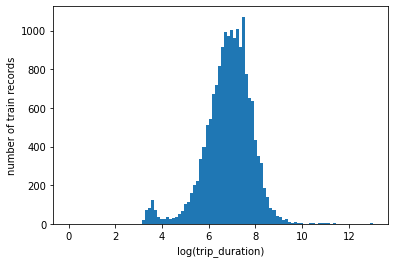

In [59]:
features_df['log_trip_duration'] = np.log(features_df['duration'].values + 1)
plt.hist(features_df['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
features_df = features_df.drop([ 'log_trip_duration'], axis = 1)

In [0]:
scaler = StandardScaler()
features = scaler.fit_transform(features_df.values)
features_df = pd.DataFrame(features, index=features_df.index, columns=features_df.columns)

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [0]:
# A parameter grid for lgb
params = {
        'max_depth':range(3,16,2), 
        'min_samples_split':range(200,1001,200),
        'min_samples_leaf':range(30,71,10),
        'subsample':[0.8,0.85],
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
        'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
        }

In [0]:
# grid search
lgb1 = lgb.LGBMClassifier(learning_rate=0.004, n_estimators=5000, random_state=10, objective='binary', boosting_type='goss', silent=True, nthread=4)

grid = GridSearchCV(estimator=lgb1, param_grid=params, scoring='f1_macro', n_jobs=4, cv=5, verbose=3)
grid.fit(features_df, labels_df.values.ravel())
grid.best_params_, grid.best_score_

In [0]:
# classifier
clf = lgb.LGBMClassifier(learning_rate=0.004, n_estimators=5000, max_depth=7, min_samples_split=200, min_samples_leaf=30, random_state=10, subsample=0.8, 
                         reg_alpha = 0.1, reg_lambda = 1, objective = 'binary', boosting_type='goss')

In [65]:
%%time

# Train model
clf.fit(X_train, y_train.values.ravel())

None   # don't print out the whole pipeline representation

CPU times: user 38.3 s, sys: 636 ms, total: 38.9 s
Wall time: 19.9 s


In [0]:
# Predict on evaluation set
preds = clf.predict(X_eval)

In [67]:
y_preds = pd.DataFrame(
    {
        "label": preds,
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)

y_preds.shape: (5669, 1)


In [68]:
f1_score(y_eval, y_preds, average='macro')

0.8432745370179092

In [26]:
# retrain on full dataset
%%time 

clf.fit(features_df, labels_df.values.ravel())

None   # So we don't print out the whole pipeline representation

CPU times: user 48.7 s, sys: 708 ms, total: 49.4 s
Wall time: 25.2 s


In [0]:
preds1 = clf.predict(test_features_df)

In [0]:
submission_df = pd.read_csv(DATA_PATH / "/content/drive/My Drive/ML/sample_submission.csv", 
                            index_col="tripid")

In [0]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

In [0]:
# Save predictions to submission data frame
submission_df["prediction"] = preds1

In [0]:
submission_df.to_csv('my_submission.csv', index=True)